# Implementing LSTMs using TensorFlow

This notebook walks you through the implementation of an Long Short-Term Memory (LSTM) model to classify news headlines as sarcastic or not_sarcastic. We will analyse the accuracy & loss curves for training and validation sets.

In [2]:
##import the required libraries and APIs
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.13.1


#### Downloading the Headlines data


In [4]:
import pandas as pd

# Download Kaggle Dataset
data = pd.read_json('data/Sarcasm_Headlines_Dataset.json', lines=True)

data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
##create arrays to store the headlines and labels
headlines = list(data['headline'])
labels = list(data['is_sarcastic'])

headlines[:5]  # First 5 lines

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

#### Data Preparation

In [7]:
## Define parameters for tokenizing and padding
vocab_size = 10000            # Maximum number of words in the vocabulary
max_length = 150              # Maximum length of sequences (padding/truncation)
embedding_dim = 32            # Dimensionality of the embedding vector
trunc_type = 'post'           # Specify truncation type for sequences longer than max_length (options: 'pre', 'post')
padding_type = 'post'         # Specify padding type for sequences shorter than max_length (options: 'pre', 'post')
oov_tok = "<OOV>"             # Out-of-vocabulary token to handle unknown words
training_size = 20000         # Size of the training data (index)

In [8]:
##training set from 0 to training size
training_sentences = headlines[0:training_size]
training_labels = labels[0:training_size]

##testing set from training size to the end
testing_sentences = headlines[training_size:]
testing_labels = labels[training_size:]

In [9]:
##train the tokenizer on training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

##create training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

##create test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [10]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

## Define the LSTM model with the following layers:
1. Embedding layer
2. Add two bidirectional LSTM layers with 64 and 32 as number of outputs.
3. Dense layer with 24 nodes
4. Output Dense layer with `sigmoid` activation 

In [12]:
## Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),  # Embedding layer to convert words to vectors
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # Bidirectional LSTM with 64 units (True for stacking LSTM layers)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),                        # Another Bidirectional LSTM with 32 units
    tf.keras.layers.Dense(24, activation='relu'),             # Dense layer with 24 units and ReLU activation
    tf.keras.layers.Dense(1, activation='sigmoid')            # Output layer with 1 unit and sigmoid activation for binary classification
])

## Compile the model with loss function, optimizer, and metrics
model.compile(loss='binary_crossentropy',  # Loss function for binary classification
              optimizer='adam',            # Adam optimizer
              metrics=['accuracy'])        # Metrics to evaluate the model performance

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 32)           320000    
                                                                 
 bidirectional (Bidirection  (None, 150, 128)          49664     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 412465 (1.57 MB)
Trainable params: 412465 

In [14]:
## Train the model
num_epochs = 30             # Number of epochs to train the model

history = model.fit(
    training_padded,                                   # Training data (padded sequences)
    training_labels,                                   # Training labels
    epochs=num_epochs,                                 # Number of epochs to train
    validation_data=(testing_padded, testing_labels),  # Validation data and labels
    verbose=2                                          # Verbosity mode (2 for detailed output)
    )

Epoch 1/30
625/625 - 124s - loss: 0.4053 - accuracy: 0.8045 - val_loss: 0.3324 - val_accuracy: 0.8545 - 124s/epoch - 199ms/step
Epoch 2/30
625/625 - 110s - loss: 0.2109 - accuracy: 0.9136 - val_loss: 0.3449 - val_accuracy: 0.8536 - 110s/epoch - 176ms/step
Epoch 3/30
625/625 - 113s - loss: 0.1224 - accuracy: 0.9546 - val_loss: 0.4265 - val_accuracy: 0.8498 - 113s/epoch - 181ms/step
Epoch 4/30
625/625 - 126s - loss: 0.0700 - accuracy: 0.9765 - val_loss: 0.5083 - val_accuracy: 0.8436 - 126s/epoch - 201ms/step
Epoch 5/30
625/625 - 133s - loss: 0.0443 - accuracy: 0.9850 - val_loss: 0.6526 - val_accuracy: 0.8420 - 133s/epoch - 212ms/step
Epoch 6/30
625/625 - 130s - loss: 0.0298 - accuracy: 0.9902 - val_loss: 0.7151 - val_accuracy: 0.8405 - 130s/epoch - 208ms/step
Epoch 7/30
625/625 - 127s - loss: 0.0183 - accuracy: 0.9945 - val_loss: 0.7994 - val_accuracy: 0.8392 - 127s/epoch - 203ms/step
Epoch 8/30
625/625 - 124s - loss: 0.0157 - accuracy: 0.9952 - val_loss: 0.9056 - val_accuracy: 0.8360 - 

So we are done training and if you see we have a training accuracy of close to 100% and the validation accuracy if you see, it's close to 83% or 84%. Now let's quickly visualize the accuracy and the loss for training and validation. 

## Visualize accuracy and loss

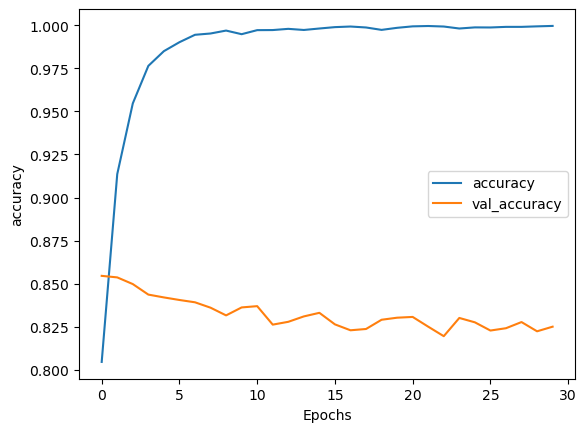

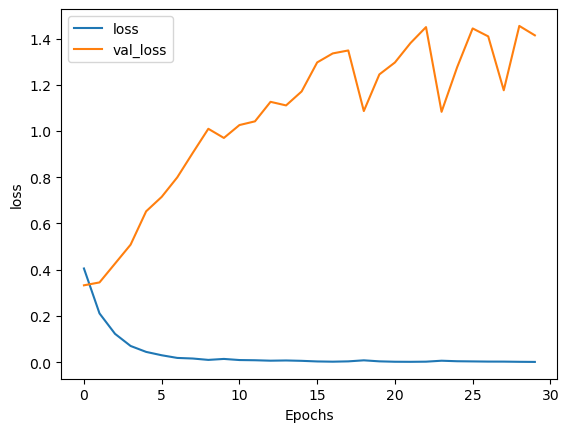

In [17]:
import matplotlib.pyplot as plt


def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
  
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

So here, if you see the accuracy curve, the training accuracy, the blue line is touching one whereas the orange line, the validation accuracy. So there's quite a bit of gap between the two which basically indicates that there's a bit of overfitting in this model.

## Classifying unseen headlines

In [20]:
sentence = ["the girl starting to fear snakes in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 2s 2s/step
[[5.8621602e-08]
 [9.4238925e-04]]


So we have defined two sentences. "The girl starting the first snakes "in the garden might be real," and "Game of Thrones season finale showing this Sunday night." So if you see, we have both of them close to zero so that there's both of the sentences have been marked or classified as *not sarcastic*. Whereas the first one seems to be kind of sarcastic. So, that was how you can use bi-directional LSTM to a model to classify a news headlines.

# Improving the performance of the Text Classifier with CNN
This notebook covers tries to explore the CNN model by replacing the LSTM model implemented in the previous video. We'll compare the accuracy and loss for a CNN model on the same headlines data.

#### Segregating the headlines

In [24]:
##create arrays to store the headlines and labels
headlines = list(data['headline'])
labels = list(data['is_sarcastic'])

headlines[:5]  # First 5 lines

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

In [25]:
## Define parameters for tokenizing and padding
vocab_size = 10000            # Maximum number of words in the vocabulary
max_length = 100              # Maximum length of sequences (padding/truncation)
embedding_dim = 64            # Dimensionality of the embedding vector
trunc_type = 'post'           # Specify truncation type for sequences longer than max_length (options: 'pre', 'post')
padding_type = 'post'         # Specify padding type for sequences shorter than max_length (options: 'pre', 'post')
oov_tok = "<OOV>"             # Out-of-vocabulary token to handle unknown words
training_size = 20000         # Size of the training data (index)

In [26]:
##training set from 0 to training size
training_sentences = headlines[0:training_size]
training_labels = labels[0:training_size]

##testing set from training size to the end
testing_sentences = headlines[training_size:]
testing_labels = labels[training_size:]

#### Tokenize the data

In [28]:
##train the tokenizer on training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

##create training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

##create test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [29]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

#### Define the neural network model with the following layers:
1. Embedding layer
2. Replace the bidirectional LSTM layers with convolutional layers with a filter size of 5.
3. GlovalAveragePooling Layer to down sample the feature map.
4. Dense layer with 24 nodes
5. Output Dense layer with `sigmoid` activation

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),  #<====== convolutions 5 words long
    tf.keras.layers.GlobalAveragePooling1D(),   
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            20544     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 662129 (2.53 MB)
Trainable params: 662129 (2.53 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

We had an input size the max land of hundred by 64. And then in the convolution, if you look at the output so if we have 96 and the number of convolutions is 64. So how did it go from a hundred to 96? So basically as the size of the input was a hundred words and we have a filter that is five words long. So that will basically print two word from the front and do word from the back, leaving us with only 96 words. So the 64 filters that we have specified will show up in the model. So total number of parameters to train, we have 662,000 parameters and we are going to train it for 10 a box providing all of the training sequences as well as the validation sequences. 

In [33]:
num_epochs = 10

history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                                     verbose=2)

Epoch 1/10
625/625 - 11s - loss: 0.4740 - accuracy: 0.7602 - val_loss: 0.3711 - val_accuracy: 0.8343 - 11s/epoch - 18ms/step
Epoch 2/10
625/625 - 12s - loss: 0.2510 - accuracy: 0.8989 - val_loss: 0.3915 - val_accuracy: 0.8332 - 12s/epoch - 19ms/step
Epoch 3/10
625/625 - 12s - loss: 0.1666 - accuracy: 0.9359 - val_loss: 0.4010 - val_accuracy: 0.8475 - 12s/epoch - 19ms/step
Epoch 4/10
625/625 - 10s - loss: 0.1067 - accuracy: 0.9620 - val_loss: 0.4463 - val_accuracy: 0.8435 - 10s/epoch - 16ms/step
Epoch 5/10
625/625 - 11s - loss: 0.0652 - accuracy: 0.9791 - val_loss: 0.5565 - val_accuracy: 0.8372 - 11s/epoch - 18ms/step
Epoch 6/10
625/625 - 10s - loss: 0.0388 - accuracy: 0.9877 - val_loss: 0.6749 - val_accuracy: 0.8326 - 10s/epoch - 16ms/step
Epoch 7/10
625/625 - 11s - loss: 0.0214 - accuracy: 0.9944 - val_loss: 0.8076 - val_accuracy: 0.8341 - 11s/epoch - 17ms/step
Epoch 8/10
625/625 - 9s - loss: 0.0133 - accuracy: 0.9964 - val_loss: 0.8679 - val_accuracy: 0.8325 - 9s/epoch - 14ms/step
Ep

We have a training accuracy of again close to a hundred percent. And the validation accuracy is somewhere around 83%. So, it's exactly kind of similar to what we had with the LSTM model.

#### Visualize the accuracy and loss

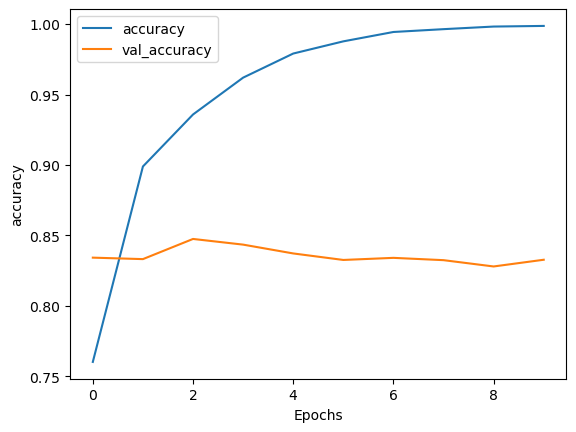

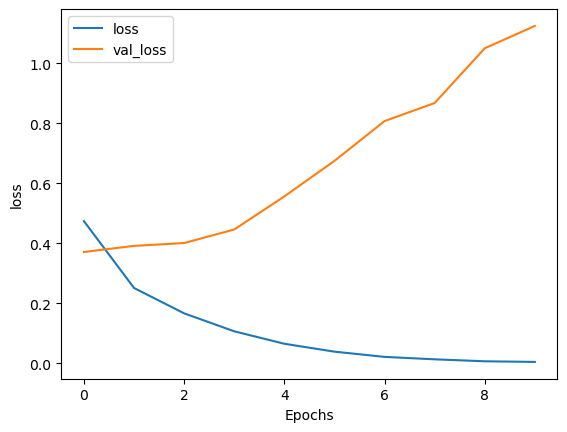

In [36]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

We do not have any spikes in the validation as we did in the LSTM. So here, the curves are a little smoother but there is still a gap between the accuracy and the loss. If you see the validation loss is higher. So that kind of indicates towards all fitting.

#### Classifying new sentences

In [39]:
sentence = ["the girl starting to fear snakes in the garden might be real", "game of thrones season finale showing this sunday night"]

sequences = tokenizer.texts_to_sequences(sentence)

padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(model.predict(padded))

1/1 [==============================] - 0s 53ms/step
[[0.00108799]
 [0.00264617]]


So this model is also classifying the two sentences as non sarcastic.